#**Mount Google Drive for file access**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#**Import dependencies**

In [2]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
from keras.models import Model,load_model
from keras.layers import Conv2D, Dense, MaxPooling2D, Input, Flatten

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

#**Create Directories for input and checkpoints**

In [4]:
input_path = "/content/gdrive/MyDrive/ConcreteCrackDetection/input"
checkpoint_dir = '/content/gdrive/MyDrive/ConcreteCrackDetection/checkpoint'
os.makedirs(input_path,exist_ok=True)
os.makedirs(checkpoint_dir,exist_ok=True)

#**Extract zip file in the input folder**

In [ ]:
os.chdir('/content/gdrive/MyDrive/ConcreteCrackDetection')
!unzip archive.zip -d input

#**Preprocess**

In [6]:
#define path for input files
POS_PATH = os.path.join(input_path,'Positive')
NEG_PATH = os.path.join(input_path,'Negative')

#preprocess image
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg')
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg')

In [7]:
#Label the dataset
positives = tf.data.Dataset.zip((positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(positive))))).take(2000) #Only taking 2000 due to lack of computational resources
negatives = tf.data.Dataset.zip((negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(negative))))).take(2000) #Only taking 2000 due to lack of computational resources
data = positives.concatenate(negatives)

#Resize and scale
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(200,200))
    img = tf.cast(img,tf.float32)/255. #byte returns uint so convert it to float and then scale the image
    return img
#compile input_img and label
def preprocess_compile(input_img,label):
    return (preprocess(input_img),label)

In [8]:
data = data.map(preprocess_compile)
data = data.cache()
data = data.shuffle(buffer_size=1024)
train_data = data.take(round(len(data)*.7)) #takes 70% of total data
train_data = train_data.batch(32) #creates batch
train_data = train_data.prefetch(16) #prefetches
val_data = data.skip(round(len(data)*.7)) #skip first 70% of total data
val_data = val_data.take(round(len(data)*.15)) #takes 15%
val_data = val_data.batch(32)
val_data = val_data.prefetch(16)
test_data = data.skip(round(len(data)*.85)) #skip first 85%
test_data = test_data.take(round(len(data)*.15)) #remaining to get 100% of data
test_data = test_data.batch(32)
test_data = test_data.prefetch(16)

#**Model Setup**

In [9]:
#setup model
def get_model(input_size):
    inp = Input(shape=(input_size, input_size, 3), name='input')
    conv1 = Conv2D(64, (10, 10), activation='relu')(inp)
    maxpool1 = MaxPooling2D(64, (2, 2), padding='same')(conv1)
    conv2 = Conv2D(128, (7, 7), activation='relu')(maxpool1)
    maxpool2 = MaxPooling2D(64, (2, 2), padding='same')(conv2)
    conv3 = Conv2D(128, (4, 4), activation='relu')(maxpool2)
    maxpool3 = MaxPooling2D(64, (2, 2), padding='same')(conv3)
    conv4 = Conv2D(256, (4, 4), activation='relu')(maxpool3)
    flatten = Flatten()(conv4)
    dense1 = Dense(4096, activation='sigmoid')(flatten)
    dense2 = Dense(1, activation='sigmoid')(dense1)
    return Model(inputs=[inp],outputs=[dense2],name='model')

model = get_model(input_size=200)

In [10]:
#For model
loss_fn = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=1e-5)

#**Train and validation**

In [11]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[0]
        y = batch[1]
        y_pred = model(X,training=True)
        loss = loss_fn(y,y_pred)
    grad = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(grad,model.trainable_variables))
    return loss

In [12]:
def val_step(batch):
    X = batch[0]
    y = batch[1]
    y_pred = model(X,training=False)
    loss = loss_fn(y,y_pred)
    return loss

In [13]:
def train_val_fun(train_data,val_data,EPOCHS):
    best_val = float('inf')
    patience = 20
    current_patience = patience
    progbar = keras.utils.Progbar(len(train_data))
    for epoch in range(1,EPOCHS+1):
        total_train_loss = 0.
        total_val_loss = 0.
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        for idx,batch in enumerate(train_data):
            training_loss = train_step(batch)
            total_train_loss += training_loss
            progbar.update(idx+1)

        for idx,batch in enumerate(val_data):
            val_loss = val_step(batch)
            total_val_loss += val_loss
        avg_train_loss = total_train_loss/(idx+1)
        avg_val_loss = total_val_loss/(idx+1)

        print("Average Training Loss:{:.3f} Average Validation Loss:{:.3f}".format(avg_train_loss,avg_val_loss))

        if avg_val_loss<best_val:
            current_patience = patience
            best_val = avg_val_loss
            print("Saving Best Model")
            model.save(os.path.join(checkpoint_dir,'best_model.keras'))
        else:
            current_patience -= 1
            if current_patience == 0:
                print("Early Stopping")
                break

In [14]:
EPOCHS = 50
train_val_fun(train_data,val_data,EPOCHS)


 Epoch 1/50
88/88 [==============================] - 482s 4s/step
Average Training Loss:2.123 Average Validation Loss:0.124
Saving Best Model

 Epoch 2/50
88/88 [==============================] - 969s 863ms/step
Average Training Loss:1.013 Average Validation Loss:0.057
Saving Best Model

 Epoch 3/50
88/88 [==============================] - 1068s 868ms/step
Average Training Loss:0.461 Average Validation Loss:0.079

 Epoch 4/50
88/88 [==============================] - 1149s 850ms/step
Average Training Loss:0.421 Average Validation Loss:0.040
Saving Best Model

 Epoch 5/50
88/88 [==============================] - 1247s 856ms/step
Average Training Loss:0.349 Average Validation Loss:0.055

 Epoch 6/50
88/88 [==============================] - 1327s 845ms/step
Average Training Loss:0.376 Average Validation Loss:0.043

 Epoch 7/50
88/88 [==============================] - 1408s 843ms/step
Average Training Loss:0.423 Average Validation Loss:0.039
Saving Best Model

 Epoch 8/50
88/88 [==========

#**Load best model**

In [18]:
model = load_model(os.path.join(checkpoint_dir,'best_model.keras'))

#**Testing**

In [19]:
test_input,y_true = test_data.as_numpy_iterator().next()
y_pred = model.predict([test_input])
[1 if prediction>0.5 else 0 for prediction in y_pred]

1/1 [==============================] - 0s 119ms/step


[0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0]

In [20]:
y_true

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32)

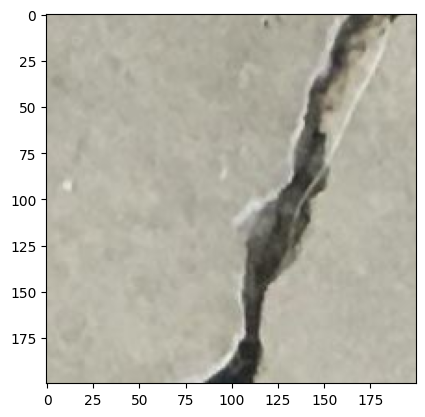

In [21]:
plt.imshow(test_input[29])
plt.show()

#**Visualisations**

In [22]:
def create_crop_and_predict(input_tensor,height_cropped:int=40,width_cropped:int=40,threshold:float=0.3):
  img_ht, img_wd, img_chann = input_tensor.shape
  assert img_ht%height_cropped==0 and img_wd%width_cropped==0, 'height_cropped or width_cropped can not divide the (H,W) of input_tensor'
  bounding_red_box = []
  bounding_green_box = []
  for i in range(0,img_ht,height_cropped):
    for j in range(0,img_wd,width_cropped):
      cropped = input_tensor[i:i+height_cropped,j:j+width_cropped]
      cropped = np.resize(cropped,(1,img_ht,img_wd,img_chann))
      y_pred = model.predict([cropped])
      if y_pred>threshold:
        bounding_red_box.append((i,i+height_cropped,j,j+width_cropped))
      else:
        bounding_green_box.append((i,i+height_cropped,j,j+width_cropped))
  return bounding_red_box, bounding_green_box

In [23]:
def color_prediction(input_tensor):
  copied = input_tensor.copy()
  bounding_red_box, bounding_green_box = create_crop_and_predict(copied)
  font = cv2.FONT_HERSHEY_SIMPLEX
  fontScale = 0.5
  thickness = 1
  for coordinates in bounding_red_box:
    color = (1,0,0)
    text = "Pos"
    roi = copied[coordinates[0]:coordinates[1],coordinates[2]:coordinates[3]]
    text_size = cv2.getTextSize(text,font,fontScale,thickness)
    overlay_mask = np.zeros_like(roi)
    overlay_mask[:] = color
    blended_roi = cv2.addWeighted(roi,0.9,overlay_mask,0.1,0)
    cv2.putText(blended_roi,text, (5,15), font, fontScale, color, thickness, cv2.LINE_AA)
    copied[coordinates[0]:coordinates[1],coordinates[2]:coordinates[3],:] = blended_roi
  for coordinates in bounding_green_box:
    color = (0,1,0)
    text = "Neg"
    roi = copied[coordinates[0]:coordinates[1],coordinates[2]:coordinates[3]]
    text_size = cv2.getTextSize(text,font,fontScale,thickness)
    overlay_mask = np.zeros_like(roi)
    overlay_mask[:] = color
    blended_roi = cv2.addWeighted(roi,0.9,overlay_mask,0.1,0)
    cv2.putText(blended_roi,text, (5,15), font, fontScale, color, thickness, cv2.LINE_AA)
    copied[coordinates[0]:coordinates[1],coordinates[2]:coordinates[3],:] = blended_roi
  return copied

1/1 [==============================] - 0s 16ms/step


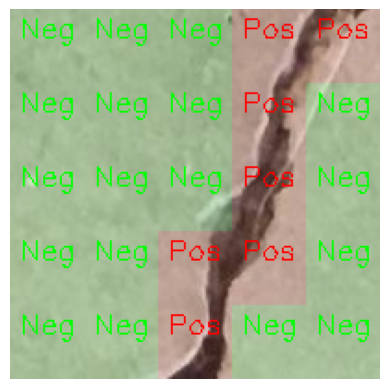

In [26]:
image = color_prediction(test_input[29])
plt.imshow(image)
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 17ms/step


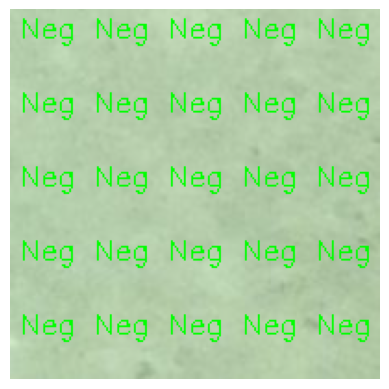

In [28]:
image = color_prediction(test_input[4])
plt.imshow(image)
plt.axis('off')
plt.show()